# Content

1. Problem Statement<br>
2. Background <br>
3. Dataset <br>
4. Data Dictionary <br>
5. Data Cleaning <br>
6. EDA <br>
7. Model Preprocessing <br>
8. Modelling
9. Model Evaluation <br>
10. Conclusion and Recommendations

## 1. Problem Statement

We are a team of Data Analyst at ABC consultancy working together with CHAT to improve their webCHAT email platform for youths to get support for emotional concerns. 

Based on the emails received from chat@mentalhealth.sg, we want to accurately assign them into "anxiety" or "depression" category and allow the counsellors to provide them the necessary support and resources.

This project aims to:<br>
(i) Use the reviews from Reddit for r/Anxiety and r/depression and apply Naive Bayes, K-Nearest Neighbors and Logistic Regression modelling to predict if they fall under the anxiety or depression subreddit.<br>
(ii) Find out the words commonly used by both subreddits.

## 2. Background

Due to COVID-19, it resulted in a large group of Singaporeans experiencing anxiety or depression - 1 in 3 adults anxious, depressed. Younger adults, aged 35 and under, were more likely to experience psychological distress than those over the age of 35 due to their greater access to COVID-19 information through the media ([*source*](https://www.duke-nus.edu.sg/allnews/covid-19-1-in-3-adults-anxious-depressed)).

CHAT is the Centre of Excellence for Youth Mental Health in Singapore, which have been helping and supporting young people with mental health concerns since 2009. CHAT runs a national youth mental health outreach and assessment service for youth and young adults aged 16 to 30 ([*source*](https://www.imh.com.sg/CHAT/Pages/default.aspx)).

Young adults in Singaporeans who have experienced psychological distress due to COVID-19 may seek platforms such as CHAT to receive support. Improvements made to CHAT's webCHAT email platform would accurately identify if the subject was experiencing anxiety or depression and allow for counsellors to provide the necessary support and resources to these youths.

## 3. Dataset

1. anxiety.csv: Includes the title and description of 3079 post on r/Anxiety <br>
2. depression.csv: Includes the title and description of 3073 post on r/depression

## 4. Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|subreddit|object|anxiety.csv/depression.csv|Type of Subreddit|
|title|object|anxiety.csv/depression.csv|Title of Post|
|selftext|object|anxiety.csv/depression.csv|Description of Post|

## 5. Data Cleaning

In [1]:
#Import Libraries

import pandas as pd
import numpy as np
import string
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score, plot_roc_curve, roc_auc_score 
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#Load files
anxiety_df = pd.read_csv('../Dataset/anxiety.csv')
depression_df = pd.read_csv('../Dataset/depression.csv')

### (i) Anxiety Dataset

Take a look at the columns 

In [2]:
anxiety_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3079 entries, 0 to 3078
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  3079 non-null   object
 1   title      3079 non-null   object
 2   selftext   2935 non-null   object
dtypes: object(3)
memory usage: 72.3+ KB


Identify columns with null values

In [3]:
#selftext has null values but not title

anxiety_df.isnull().sum()

subreddit      0
title          0
selftext     144
dtype: int64

In our analysis, we shall merge both columns together

In [4]:
#if there is both title and selftext, merge both columns together
anxiety_df['title_selftext'] = anxiety_df ['title'] + ' ' + anxiety_df['selftext']

#if there is empty selftext columns, to take only the title column
anxiety_df['title_selftext'] = anxiety_df['title_selftext'].fillna(anxiety_df['title'])

Take a look at merge column - title_selftext

In [57]:
anxiety_df.head()

,subreddit,title,selftext,title_selftext
0,Anxiety,My ex friend said me having anxiety is abusive...,Um hi i’m new to the sub and hoped someone cou...,My ex friend said me having anxiety is abusive...
1,Anxiety,Just wanted to share,"Hey everyone , so my anxiety has been up to\na...","Just wanted to share Hey everyone , so my anxi..."
2,Anxiety,Anxious about polygraph at work,"\n\nI managed to get out of my old, toxic jo...",Anxious about polygraph at work \n\nI manage...
3,Anxiety,DAE get waves of vertigo even when sitting or ...,Vertigo has been one of my main symptoms of an...,DAE get waves of vertigo even when sitting or ...
4,Anxiety,Is there someone that I can talk to right now?,Just really need to talk to someone,Is there someone that I can talk to right now?...


Generate a new df with only the title_selftext column

In [5]:
anxiety_clean_df = anxiety_df.drop(columns = ['title', 'selftext'])

Post in reddit may contain [removed] or [deleted]. We want to remove these words in our analysis.

In [6]:
anxiety_clean_df["title_selftext"] = anxiety_clean_df["title_selftext"].apply(lambda x: x.replace("[removed]", " "))
anxiety_clean_df["title_selftext"] = anxiety_clean_df["title_selftext"].apply(lambda x: x.replace("[deleted]", " "))

Take a look at the first 5 entries of the new df

In [7]:
anxiety_clean_df.head()

,subreddit,title_selftext
0,Anxiety,My ex friend said me having anxiety is abusive...
1,Anxiety,"Just wanted to share Hey everyone , so my anxi..."
2,Anxiety,Anxious about polygraph at work \n\nI manage...
3,Anxiety,DAE get waves of vertigo even when sitting or ...
4,Anxiety,Is there someone that I can talk to right now?...


### (ii) Depression Dataset

Take a look at the columns

In [8]:
depression_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3073 entries, 0 to 3072
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  3073 non-null   object
 1   title      3073 non-null   object
 2   selftext   3046 non-null   object
dtypes: object(3)
memory usage: 72.1+ KB


Identify columns with null values

In [9]:
#selftext has null values but not title

depression_df.isnull().sum()

subreddit     0
title         0
selftext     27
dtype: int64

In our analysis, we shall merge both columns together

In [10]:
#if there is both title and selftext, merge both columns together
depression_df['title_selftext'] = depression_df ['title'] + ' ' + depression_df['selftext']

#if there is empty selftext columns, to take only the title column
depression_df['title_selftext'] = depression_df['title_selftext'].fillna(depression_df['title'])

Take a look at merge column - title_selftext

In [11]:
depression_df.head()

,subreddit,title,selftext,title_selftext
0,depression,Does therapy help,Just wondering if therapy even does anything b...,Does therapy help Just wondering if therapy ev...
1,depression,How do I stop the cycle?,I have been super depressed for about 4 years ...,How do I stop the cycle? I have been super dep...
2,depression,Confused and lost,Is it just me or does anyone else feel more an...,Confused and lost Is it just me or does anyone...
3,depression,I'm giving up. last therapy appointment today,"Its 330 am. Its been 2 years of ""therapy"". 3 y...",I'm giving up. last therapy appointment today ...
4,depression,negative butterflys,[removed],negative butterflys [removed]


Generate a new df with only the title_selftext column

In [12]:
depression_clean_df = depression_df.drop(columns = ['title', 'selftext'])

Post in reddit may contain [removed] or [deleted]. We want to remove these words in our analysis.

In [13]:
depression_clean_df["title_selftext"] = depression_clean_df["title_selftext"].apply(lambda x: x.replace("[removed]", " "))
depression_clean_df["title_selftext"] = depression_clean_df["title_selftext"].apply(lambda x: x.replace("[deleted]", " "))

Take a look at the first 5 entries of the new df

In [14]:
depression_clean_df.head()

,subreddit,title_selftext
0,depression,Does therapy help Just wondering if therapy ev...
1,depression,How do I stop the cycle? I have been super dep...
2,depression,Confused and lost Is it just me or does anyone...
3,depression,I'm giving up. last therapy appointment today ...
4,depression,negative butterflys


### (iii) Merging of Dataframes

In [15]:
df_merge = pd.merge(anxiety_clean_df, depression_clean_df, how='outer')

In [16]:
#take a look at the combined clean df
#anxiety csv has 3079 submissions
#depression csv has 3073 submissions
#total submission: 6152

df_merge

,subreddit,title_selftext
0,Anxiety,My ex friend said me having anxiety is abusive...
1,Anxiety,"Just wanted to share Hey everyone , so my anxi..."
2,Anxiety,Anxious about polygraph at work \n\nI manage...
3,Anxiety,DAE get waves of vertigo even when sitting or ...
4,Anxiety,Is there someone that I can talk to right now?...
...,...,...
6147,depression,How can i help my My friend how is plannig sui...
6148,depression,if you have depression
6149,depression,A message I sent to someone. Thought I'd get s...
6150,depression,Why am I still here? It's been just over 4 mon...


## 6. EDA

In [17]:
# Create function to remove punctuation, tokenize, remove stopwords, and lemmatize

def clean_text(text):
    
    #define wn and stopword
    wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('english')
    
    # store character only if it is not a punctuation
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    
    # \W matches any non-word character (equivalent to [^a-zA-Z0-9_]). This does not include spaces i.e. \s
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    
    # apply lemmatization and stopwords exclusion within the same step
    text = " ".join([wn.lemmatize(word) for word in tokens if word not in stopword])
    
    #remove numbers and word with numbers
    text = "".join([re.sub('\d+', "", word) for word in text])
    
    #remove words which are not in english
    text = "".join([word for word in text if word.isascii() == True])
    
    #remove ''
    text = "".join([word for word in text if word != ''])
    
    return text

In [18]:
#create function to gen shape after count vectorizer and plot top 20 words/2-words/3-words

def count_vectorizer (y, z, n):
    # Create an instance of CountVectorizer
    count_vect = CountVectorizer(ngram_range=(n, n))

    # X_counts stores the vectorized version of the data
    y['clean_title_selftext'] = y['title_selftext'].apply(lambda x: clean_text(x))
    X_counts = count_vect.fit_transform(y['clean_title_selftext'])

    # Returns the number of rows and columns of X_counts
    print(f'(number of rows, number of unique words/phrases): {X_counts.shape}')

    # Due to the nature of sparse matrices where only non-zero elements are stored, 
    # we would need to expand it out to a collection of arrays and then store it in a data frame
    X_counts_df = pd.DataFrame(X_counts.toarray())

    #get features name over df
    X_counts_df.columns = count_vect.get_feature_names()
    
    #get sum of each column
    X_counts_df = X_counts_df.sum()
    
    #sort values
    X_counts_df.sort_values(ascending = False, inplace = True)
    
    #put into a df
    X_counts_df = X_counts_df.iloc[:20].to_frame()

    # Plot the top 20 words for the subreddit in a bar chart
    X_counts_bar = X_counts_df.plot(kind = 'bar', figsize = (12,8), fontsize = 10)

    # Set the title, x & y labels and remove legend
    X_counts_bar.set_title(z + ' Subreddit Top 20 Unique Words/Phrases', fontsize=15)
    X_counts_bar.get_legend().remove()
    X_counts_bar.set_ylabel('Words', fontsize=10)
    X_counts_bar.set_xlabel('Count', fontsize=10)
    plt.xticks(rotation=45);

### Top 20 word/phrases in Anxiety subreddit

(number of rows, number of unique words/phrases): (3079, 12919)


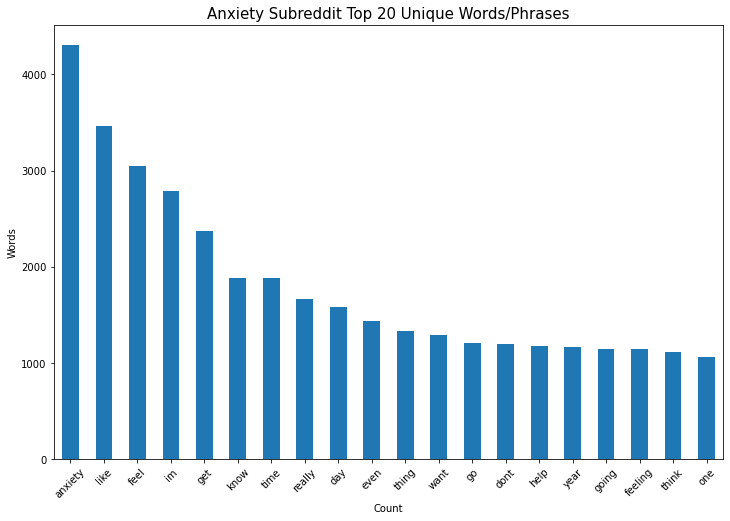

In [19]:
#top 20 words

count_vectorizer (anxiety_clean_df, "Anxiety", 1)

Words like 'anxiety' shows that people who are anxious often are aware of what and how they are feeling. The top 20 words list contains common words such as 'feel' and 'feeling' since anxious is a type of feeling. The word 'help' could perhaps show that the subject recognises that they need help. Couple of time-based words such as 'time', 'day' and 'year' could probably mean that the subject is experiencing such feelings for a period of time.

(number of rows, number of unique words/phrases): (3079, 146251)


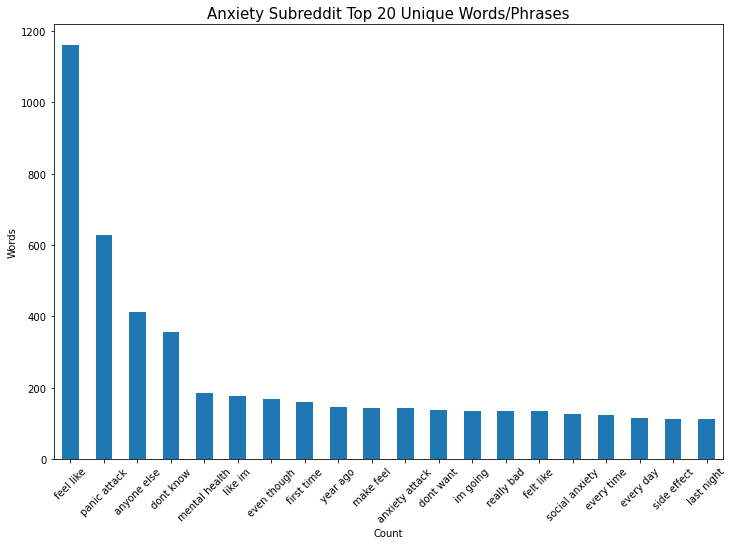

In [20]:
#top 20 2-word phrases

count_vectorizer (anxiety_clean_df, "Anxiety", 2)

Phrases like "panic attack", "anxiety attack" and "social anxiety" are associated with anxiety. Similarly, there are a couple of time-based phrases such as "year ago", "every time" and "every day".

(number of rows, number of unique words/phrases): (3079, 209747)


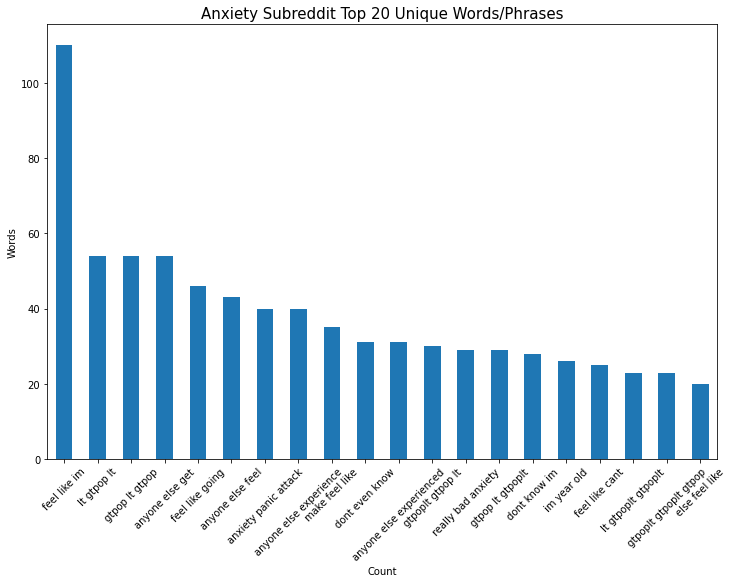

In [21]:
#top 20 3-word phrases

count_vectorizer (anxiety_clean_df, "Anxiety", 3)

Couple of anxiety related phrases such as "anxiety panic attack", "really bad anxiety" shows that people are fairly aware of signs of anxiety. There are also certain phrases used by subjects such as "anyone else get", "anyone else feel", "anyone else experienced" to obtain validation from others. Another common word seen here is "gtpopit". Upon further investigation, pop it is a type of fidget toy, which could be a common toy owned by people who are anxious.

### Top 20 word/phrases in Depression subreddit

(number of rows, number of unique words/phrases): (3073, 11972)


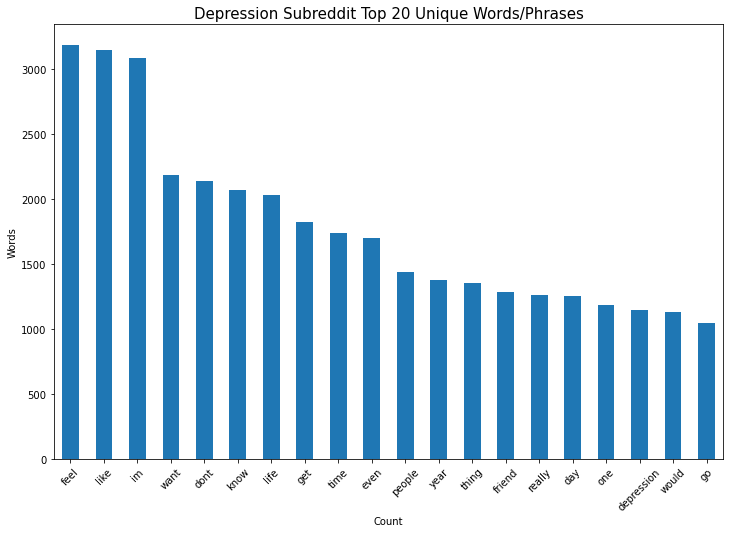

In [22]:
#top 20 words

count_vectorizer (depression_clean_df, "Depression", 1)

Words like "life" shows people with depression comtemplates about life. The word "depression" is also in the list of top 20 words. However, the number of times depression appears is lower than the number of times anxiety appears in their own subreddits. It is likely that subjects who may be suffering from depression do not talk about it so explicitly in their reddit posts.

(number of rows, number of unique words/phrases): (3073, 131517)


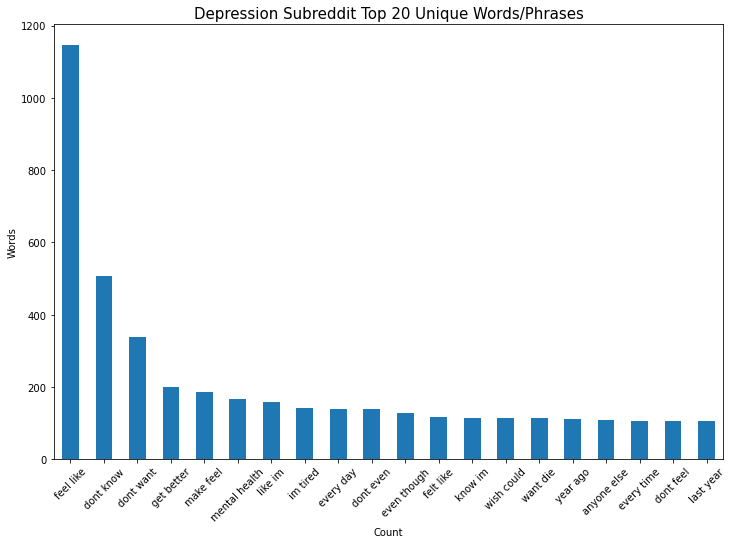

In [23]:
#top 20 2-word phrases

count_vectorizer (depression_clean_df, "Depression", 2)

Based on the words like "get better" and "wish could", it shows that people who are suffering from depression would like to feel normal. However, this is not seen in anxiety likely because depression requires a longer term treatment and intervention. Similar time-based phrases can be seen here such as "every day", "year ago" and "last year" to signify the frequency and duration of the illness. Phrases like "im tired" and "want die" shows the impact of depression to the subject in which they feel more strongly than subjects experiencing anxiety.

(number of rows, number of unique words/phrases): (3073, 189936)


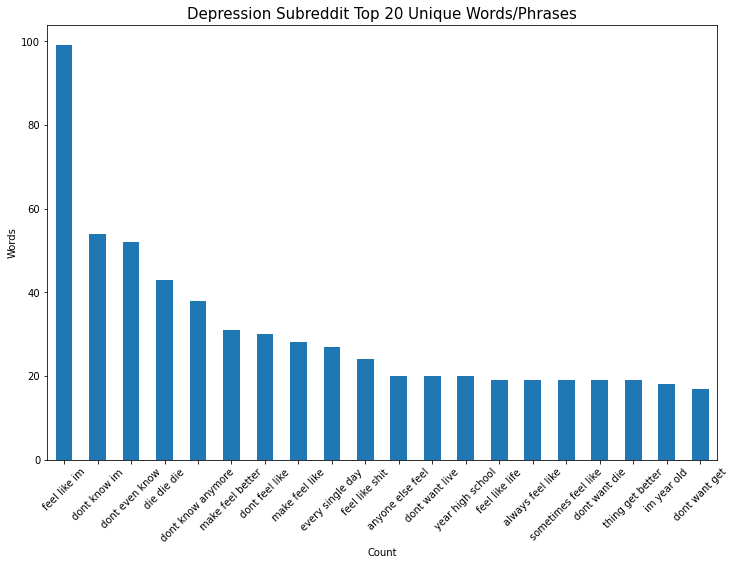

In [24]:
#top 20 3-word phrases

count_vectorizer (depression_clean_df, "Depression", 3)

Repeated "die" words can be seen in these phrases which are unlike those in the anxiety subreddits. In general there are also a lot more phrases containing the word "feel", "better" and "dont".

### Top 20 2-word phrases in Merge subreddit

(number of rows, number of unique words/phrases): (6152, 249554)


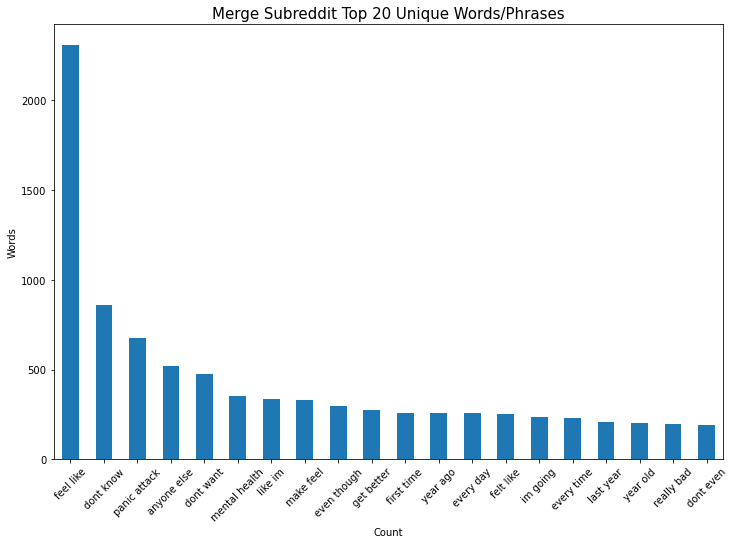

In [25]:
#top 20 2-word phrases

count_vectorizer (df_merge, "Merge", 2)

Words such are "feel like", "dont know", "anyone else", "dont want" and "mental health" can be seen repeated in both subreddits.

## 7. Model Preprocessing

### Vectorizing Raw Data: TF-IDF

Since both anxiety and depression are psychological conditions with the usuage of fairly similar words in the reddit posts, we will use TF-IDF vectorization (together with bigrams) in our models.

In [26]:
#clean the title_selftext column for the df_merge df and rename as clean_title_selftext

df_merge['clean_title_selftext'] = df_merge['title_selftext'].apply(lambda x: clean_text(x))

### TF-IDF vectorization

In [27]:
tfidf_vect = TfidfVectorizer()
X_tfidf_1 = tfidf_vect.fit_transform(df_merge['clean_title_selftext'])

#take a look at the shape of the df
print(X_tfidf_1.shape)

X_tfidf_1_df = pd.DataFrame(X_tfidf_1.toarray())
X_tfidf_1_df.columns = tfidf_vect.get_feature_names()
X_tfidf_1_df

(6152, 17892)


,aa,aaa,aaaa,aaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaahhhaa,aalis,aampe,aana,aati,...,zombie,zone,zoned,zoning,zonked,zoo,zoom,zooming,zosert,zyrtec
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### TF-IDF vectorization with bigram

In [28]:
tfidf_vect = TfidfVectorizer(ngram_range=(2, 2))
X_tfidf_2 = tfidf_vect.fit_transform(df_merge['clean_title_selftext'])

#take a look at the shape of the df
print(X_tfidf_2.shape)

X_tfidf_2_df = pd.DataFrame(X_tfidf_2.toarray())
X_tfidf_2_df.columns = tfidf_vect.get_feature_names()
X_tfidf_2_df

(6152, 249554)


,aa cant,aa meeting,aaa phone,aaa six,aaaa fucking,aaaaa aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa want,aaaahhhaa female,aalis sayang,aampe day,...,zoom spend,zoom started,zoom talk,zoom teach,zoom therapy,zoom triggered,zooming thinking,zosert asked,zosert mg,zyrtec tuesday
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 8. Modelling

We will be using the Naive Bayes, K-Nearest Neighbors and Logistic Regression models and evaulate their performance in predicting if a post belongs to the anxiety or depression subreddit. <br>

Our baseline model would be the Naive Bayes - Bernoulli model and we would be comparing the accuracy scores of Naive Bayes - Multinomial, Naive Bayes - Gaussian, K-Nearest Neighbors and Logistic Regression against the accuracy scores of the baseline model and select the model with the highest train and test set accuracy scores for 5-fold cross validation. <br>

Accuracy score is an evaluation metric that measures the number of correct predictions made by a model in relation to the total number of predictions made. We calculate it by dividing the number of correct predictions by the total number of predictions.

In [29]:
#map subreddit column to 0 or 1

subreddit_map = {'Anxiety':0, 'depression':1}

df_merge['subreddit_map'] = df_merge['subreddit'].map(subreddit_map)

In [30]:
#define X and y variables

X = X_tfidf_1_df
y = df_merge['subreddit_map']

In [31]:
#train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Baseline Model - Naive Bayes Bernoulli Classifier with TF-IDF vectorization

In [32]:
#Bernoulli

BernNB = BernoulliNB(binarize = 0.1)
BernNB.fit(X_train, y_train)

print(f'Accuracy Score for train set with Cross Validation: {cross_val_score(BernNB, X_train, y_train, cv=5).mean()}')
print(f'Accuracy Score for test set with Cross Validation: {cross_val_score(BernNB, X_test, y_test, cv=5).mean()}')

Accuracy Score for train set with Cross Validation: 0.8296477345635637
Accuracy Score for test set with Cross Validation: 0.7893671475104699


### Naive Bayes Multinomial Classifier with TF-IDF vectorization

In [33]:
#Multinomial

MultiNB = MultinomialNB()
MultiNB.fit(X_train, y_train)

print(f'Accuracy Score for train set with Cross Validation: {cross_val_score(MultiNB, X_train, y_train, cv=5).mean()}')
print(f'Accuracy Score for test set with Cross Validation: {cross_val_score(MultiNB, X_test, y_test, cv=5).mean()}')

Accuracy Score for train set with Cross Validation: 0.8530546200614332
Accuracy Score for test set with Cross Validation: 0.8036507466474893


### Naive Bayes Gaussian Classifier with TF-IDF vectorization

In [34]:
#Gaussian

GausNB = GaussianNB()
GausNB.fit(X_train, y_train)

print(f'Accuracy Score for train set with Cross Validation: {cross_val_score(GausNB, X_train, y_train, cv=5).mean()}')
print(f'Accuracy Score for test set with Cross Validation: {cross_val_score(GausNB, X_test, y_test, cv=5).mean()}')

Accuracy Score for train set with Cross Validation: 0.6683992827312617
Accuracy Score for test set with Cross Validation: 0.641759380684462


### K-Nearest Neighbors with TF-IDF vectorization

In [35]:
# apply scaling to X-variables to bring values to a similar scale for better model performance
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [36]:
#KNN

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print(f'Accuracy Score for train set with Cross Validation: {cross_val_score(knn, X_train_sc, y_train, cv=5).mean()}')
print(f'Accuracy Score for test set with Cross Validation: {cross_val_score(knn, X_test_sc, y_test, cv=5).mean()}')

Accuracy Score for train set with Cross Validation: 0.5060685823601714
Accuracy Score for test set with Cross Validation: 0.4928296459241085


### Logistic Regression with TF-IDF vectorization

In [38]:
#LR

lr = LogisticRegression()
lr.fit(X_train, y_train)

print(f'Accuracy Score for train set with Cross Validation: {cross_val_score(lr, X_train, y_train, cv=5).mean()}')
print(f'Accuracy Score for test set with Cross Validation: {cross_val_score(lr, X_test, y_test, cv=5).mean()}')

Accuracy Score for train set with Cross Validation: 0.8714765818337356
Accuracy Score for test set with Cross Validation: 0.8511125682135454


### Hyperparameter Tuning to identify the best set of parmaeters for LR with TF-IDF vectorization

Since Logistic Regression showed the best accuracy scores, we can apply hyperparameter tuning to identify the best set of parameters for the model.

#### GridSearch CV

In [41]:
#the parameters used in the gridsearch CV are commented below

params = {"solver":['newton-cg'], #['lbfgs', 'liblinear']
          "penalty": ['l2'], #['l1', 'elasticnet', 'none']
          'C': [1.0], #[100, 10]
          "class_weight": ['balanced'],
          "multi_class": ['multinomial'] #['ovr']
         }

lr = LogisticRegression(max_iter = 1000)
model = GridSearchCV(lr, params, cv=5, n_jobs = -1)
model.fit(X_train, y_train)

print(f'Best Parameters: {model.best_params_}')
print(f'Best Score: {model.best_score_}')

Best Parameters: {'C': 1.0, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}
Best Score: 0.8725607105002785


In [42]:
lr = LogisticRegression(class_weight= 'balanced', multi_class= 'multinomial', solver= 'newton-cg')
lr.fit(X_train, y_train)

print(f'Accuracy Score for train set with Cross Validation: {cross_val_score(lr, X_train, y_train, cv=5).mean()}')
print(f'Accuracy Score for test set with Cross Validation: {cross_val_score(lr, X_test, y_test, cv=5).mean()}')

Accuracy Score for train set with Cross Validation: 0.8725607105002785
Accuracy Score for test set with Cross Validation: 0.8491666314141885


Train scores improved marginally with GridSearch CV.

#### Adjustment of Threshold

In [43]:
#using the parameters from GridSearch CV
lr = LogisticRegression(class_weight= 'balanced', multi_class= 'multinomial', solver= 'newton-cg')
lr.fit(X_train, y_train)

def get_predictions(probabilities, threshold):
    return [0 if prob < threshold else 1 for prob in probabilities]

threshold_list = [0.25, 0.4, 0.5, 0.6, 0.75]

for threshold in threshold_list:
    preds = get_predictions(lr.predict_proba(X_test)[:,1], threshold)
    acc = cross_val_score(lr, X_test, y_test, cv=5).mean()
    print(f'Threshold: {threshold}, Accuracy: {acc}')

Threshold: 0.25, Accuracy: 0.8491666314141885
Threshold: 0.4, Accuracy: 0.8491666314141885
Threshold: 0.5, Accuracy: 0.8491666314141885
Threshold: 0.6, Accuracy: 0.8491666314141885
Threshold: 0.75, Accuracy: 0.8491666314141885


Changing of probability threshold did not seem to affect the accuracy of the predictions.

#### Adjustment of Test Size in train test split

In [44]:
#test size = 0.1 in train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.1)

lr = LogisticRegression(class_weight= 'balanced', multi_class= 'multinomial', solver= 'newton-cg')
lr.fit(X_train, y_train)

print(f'Accuracy Score for train set with Cross Validation: {cross_val_score(lr, X_train, y_train, cv=5).mean()}')
print(f'Accuracy Score for test set with Cross Validation: {cross_val_score(lr, X_test, y_test, cv=5).mean()}')

Accuracy Score for train set with Cross Validation: 0.8751794455369343
Accuracy Score for test set with Cross Validation: 0.8474036191974823


In [45]:
#test size = 0.4 in train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.4)

lr = LogisticRegression(class_weight= 'balanced', multi_class= 'multinomial', solver= 'newton-cg')
lr.fit(X_train, y_train)

print(f'Accuracy Score for train set with Cross Validation: {cross_val_score(lr, X_train, y_train, cv=5).mean()}')
print(f'Accuracy Score for test set with Cross Validation: {cross_val_score(lr, X_test, y_test, cv=5).mean()}')

Accuracy Score for train set with Cross Validation: 0.8729353003949525
Accuracy Score for test set with Cross Validation: 0.8687569056217945


Scores are better when applying the best LG parameters and test size of 0.4 in train test split.

We will also take a look at TF-IDF with bigram vectorization for the better performing models i.e. models with accuracy scores of 80% and above for train and/or test set.

### Naive Bayes - Bernoulli with TF-IDF + bigram vectorization

In [46]:
#redefine X and y variables
X = X_tfidf_2_df
y = df_merge['subreddit_map']

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [47]:
BernNB.fit(X_train, y_train)

print(f'Accuracy Score for train set with Cross Validation: {cross_val_score(BernNB, X_train, y_train, cv=5).mean()}')
print(f'Accuracy Score for test set with Cross Validation: {cross_val_score(BernNB, X_test, y_test, cv=5).mean()}')

Accuracy Score for train set with Cross Validation: 0.5682723741078206
Accuracy Score for test set with Cross Validation: 0.5195080164135538


### Naive Bayes - Multinomial with TF-IDF + bigram vectorization

In [48]:
MultiNB.fit(X_train, y_train)

print(f'Accuracy Score for train set with Cross Validation: {cross_val_score(MultiNB, X_train, y_train, cv=5).mean()}')
print(f'Accuracy Score for test set with Cross Validation: {cross_val_score(MultiNB, X_test, y_test, cv=5).mean()}')

Accuracy Score for train set with Cross Validation: 0.8112248327273838
Accuracy Score for test set with Cross Validation: 0.7035090316849273


### Logistic Regression with TF-IDF + bigram vectorization

In [49]:
lr.fit(X_train, y_train)

print(f'Accuracy Score for train set with Cross Validation: {cross_val_score(lr, X_train, y_train, cv=5).mean()}')
print(f'Accuracy Score for test set with Cross Validation: {cross_val_score(lr, X_test, y_test, cv=5).mean()}')

Accuracy Score for train set with Cross Validation: 0.7932348303067193
Accuracy Score for test set with Cross Validation: 0.7711493718008375


Based on the accuracy scores, we can tell that TF-IDF with bigram vectorization would worsen rather than improve the accuracy scores of these models.

### Model Analysis

|Model Type|Type of Vectorization|Accuracy of train set with Cross Validation|Accuracy of test set with Cross Validation|
|---|---|---|---|
|[Baseline] Naive Bayes - Bernoulli|TF-IDF|83%|79%|
|Naive Bayes - Multinomial|TF-IDF|85%|80%|
|Naive Bayes - Gaussian|TF-IDF|67%|64%|
|K-Nearest Neighbors|TF-IDF|51%|49%|
|<b>Logistic Regression</b>|<b>TF-IDF</b>|<b>87%</b>|<b>87%</b>|
|Naive Bayes - Bernoulli|TF-IDF with bigram|57%|52%|
|Naive Bayes - Multinomial|TF-IDF with bigram|81%|70%|
|Logistic Regression|TF-IDF with bigram|79%|77%|

Based on the above models, we will select the Logistic Regression model with TF-IDF vectorization as it has the highest accuracy for both train and test set and better scores than our baseline Naive Bayes - Bernoulli model. We were also able to optimised our LR model based on hyperparameter tuning to obtain the best train and test set accuracy scores.

## 9. Model Evaluation

Other than the accuracy scores, we will also take a look at the confusion matrix and ROC curve to evaluate our Logistic Regression model.

In [50]:
#run LR model on the best set of parameters

X = X_tfidf_1_df
y = df_merge['subreddit_map']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.4)

lr = LogisticRegression(class_weight= 'balanced', multi_class= 'multinomial', solver= 'newton-cg')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

### Classification Report

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1254
           1       0.86      0.91      0.88      1207

    accuracy                           0.88      2461
   macro avg       0.88      0.88      0.88      2461
weighted avg       0.88      0.88      0.88      2461



Given precision and recall should be balanced in our project, to minimize both false negatives and false positive, we should look for high f1-score (>80%). In this case, f1-score is same as accuracy at 88% (without K-fold cross validation).

### Confusion Matrix

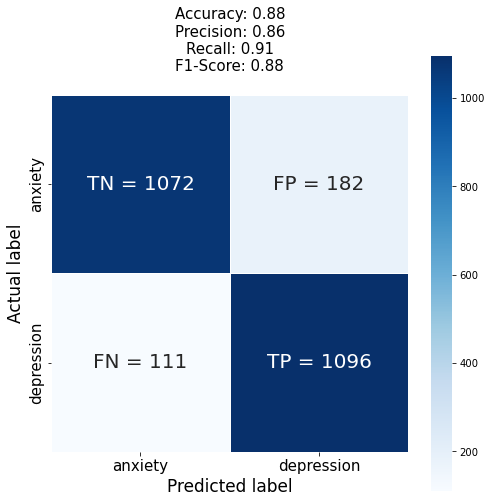

In [52]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred)

modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])  
        
score = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['anxiety', 'depression'],
            yticklabels = ['anxiety', 'depression'],
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('Accuracy: {:.2f}'.format(score)+'\n'
          +'Precision: {:.2f}'.format(precision)+'\n'
          +'Recall: {:.2f}'.format(recall)+'\n'
          +'F1-Score: {:.2f}'.format(f1)+'\n', size = 15);
plt.tick_params(labelsize= 15)

We can see here that the number of false negative (111) is lower than the number of false positives (182). Hence, recall (91%) is slightly higher than precision (86%). The f1-score will be relied upon since we want a balance between both recall and precision. In our project, we want to minimize both false positive and false negative to ensure that we do not delay the support we provide to our subjects facing anxiety or depression related issues. In this case, our f1-score is fairly high at 88% (>80%). 

### ROC Curve

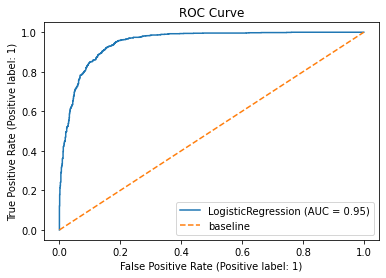

In [53]:
#ROC

plot_roc_curve(lr, X_test, y_test)
plt.plot([0, 1], [0, 1], # coordinates, two ends of the x and y axis
         label='baseline', linestyle='--') #worst model where AUC = 0.5
plt.title('ROC Curve')
plt.legend();

In [54]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

0.9494667602198235

AUC for the ROC curve performed well at 0.95 which is close to 1. This means that true positive rate is maximised and false positive rate is minimised.

### Logistic Regression Coefficients

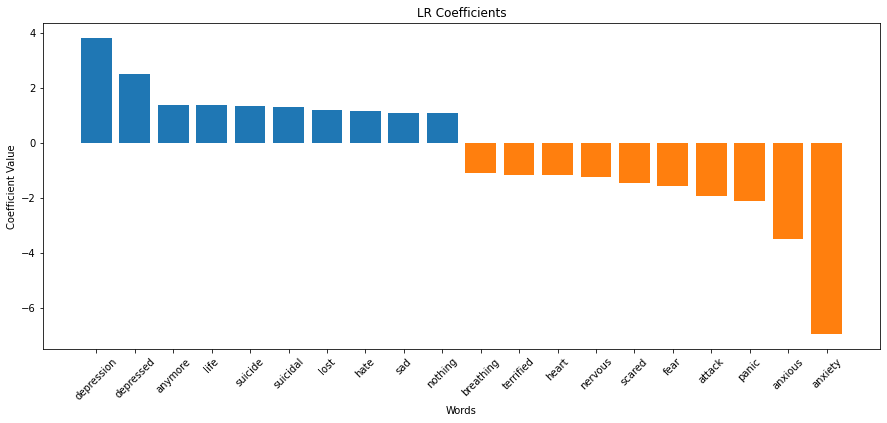

In [56]:
#coefficients of LR

# Create df for storing coefficients and their corresponding variable names
coefficient_df = pd.DataFrame()

# Storing all the column names of predictors
coefficient_df['Column_Name'] = X_train.columns

# Store coefficients of predictors (flatten from 2D to 1D array)
coefficient_df['Coefficient_Value'] = pd.Series(lr.coef_.flatten())

#sort words according to their coefficient value
coefficient_df.sort_values(by='Coefficient_Value', ascending = False, inplace = True)

# Plot the coefficent values of top 10 words with highest and lowest coefficient values
plt.rcParams['figure.figsize'] = (15,6)
plt.bar(coefficient_df["Column_Name"].head(10), coefficient_df['Coefficient_Value'].head(10))
plt.bar(coefficient_df["Column_Name"].tail(10), coefficient_df['Coefficient_Value'].tail(10))
plt.title("LR Coefficients")
plt.xlabel("Words")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45);

We can also use the coefficients of the Logistic Regression model to take a look at the words which have a higher weightage (highest or lowest coefficient value) to determine if the post belongs to the anxiety or depression subreddit. <br>

No surprise that 'depression', 'depressed', 'anxious' and 'anxiety' has highest coefficient values. Moreover, these top 10 words with highest or lowest coefficient values are closely related to either anxiety or depression.

## 10. Conclusion and Recommendations

The aim of the project was to come up with a model which can predict whether a post from reddit was from the anxiety or depression subreddit and identify words commonly used by both communities by analysing the words from the title and description of these posts.<br>

Given that both condition are psychologial conditions which can be fairly closely interlinked, words such are "feel like", "dont know", "anyone else", "dont want" and "mental health" can be seen repeated in both subreddits.<br>

Through our modelling, we identified that the Logistic Regression model using TF-IDF-unigram vectorization performed the best out of all the models with a accuracy of 88% (without K-fold Cross Validation), f1-score of 88% and AUC of 0.95.<br>

We believe our model can be implemented into CHAT's webCHAT email platform to accurately identify if the subject was experiencing anxiety or depression and allow for counsellors to provide the necessary support and resources to these youths.

Limitations: <br>
- Given that the words used by both the anxiety and depression communities may be fairly similar, there might be a limitation at how well our model can make prediction with high accuracies (>95%). Hence, our recommendations as per point 2 below.

Recommendations: <br>
1. As there are many other pyschological conditions that different subjects may be suffering from, we can perhaps include posts from other subreddits in our studies to improve our model to be able to predict other conditions.
2. We can refer to posts from other platforms and forums to improve our model's accuracy with more variation in data sources.